In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time
import importlib
from mpl_toolkits.mplot3d import Axes3D
import methods as met


importlib.reload(met)

<module 'methods' from 'c:\\Users\\Philipp\\Desktop\\StatML project\\stml-covariate-shift\\codes\\methods.py'>

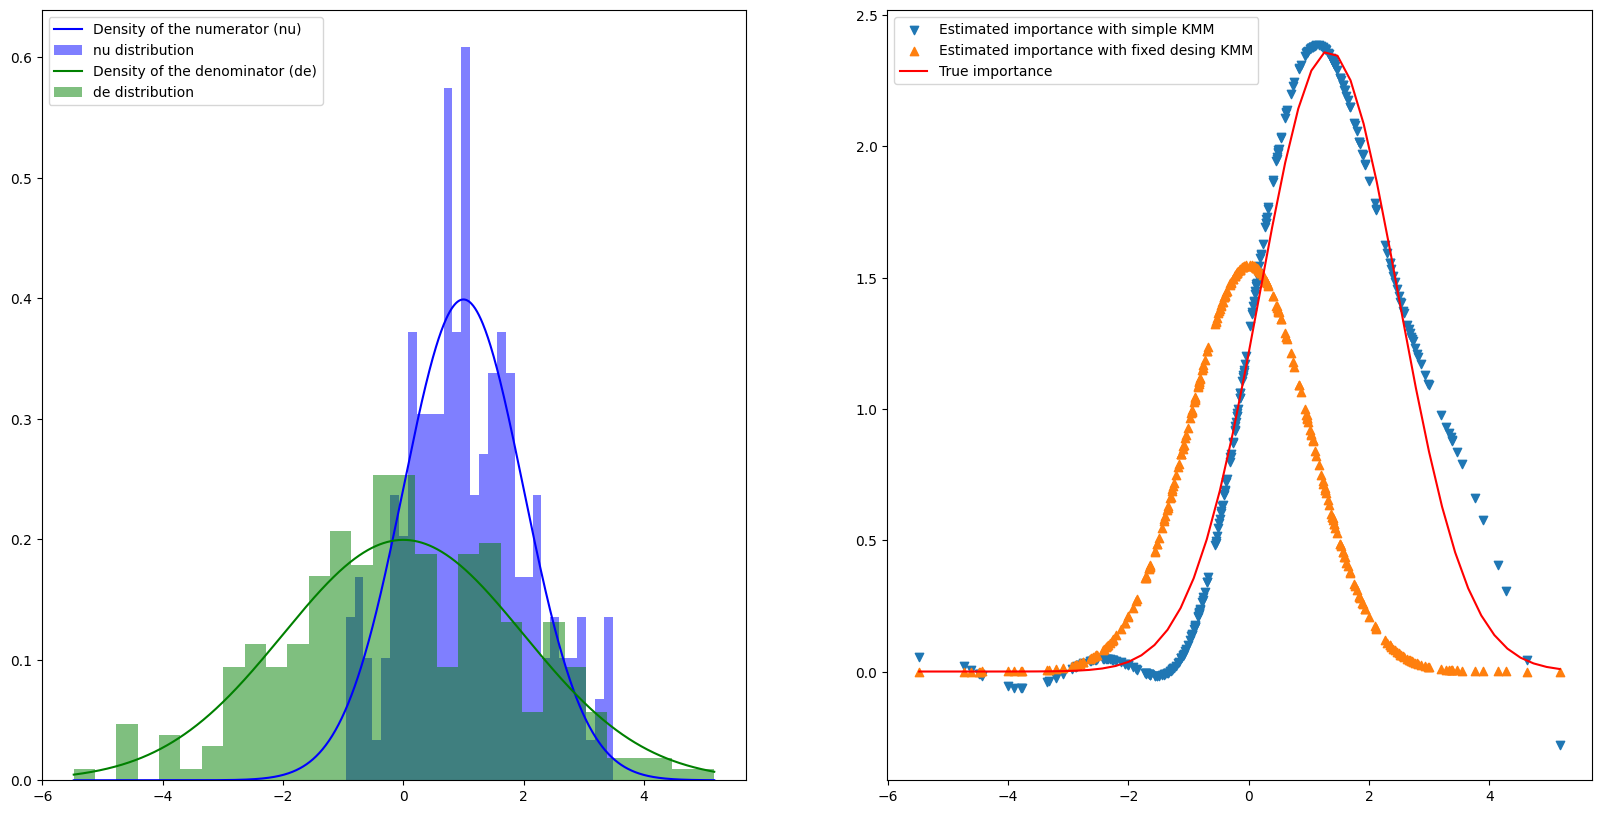

In [4]:
plot_precision = 1000




n_nu = 200
n_de = 300
#np.random.seed(1)
mu_nu, sigma_nu = 1, 1
mu_de, sigma_de = 0, 2

nu_data = np.random.normal(loc = mu_nu, scale = sigma_nu, size = n_nu)
de_data = np.random.normal(loc = mu_de, scale = sigma_de, size = n_de)

f_nu = lambda x: 1/np.sqrt(2*np.pi*sigma_nu**2)*np.exp(-(x - mu_nu)**2/(2*sigma_nu**2))
f_de = lambda x: 1/np.sqrt(2*np.pi*sigma_de**2)*np.exp(-(x - mu_de)**2/(2*sigma_de**2))

w = lambda x: f_nu(x)/f_de(x)

#x = np.linspace(-5,5, plot_precision)

tmp_nu = list(nu_data)
tmp_de = list(de_data)

n_nu = len(nu_data)
n_de = len(de_data)
l = []


for i in range(n_nu):
    for j in range(n_de):
        l.append(np.linalg.norm(nu_data[i]- de_data[j]))

#combined = sorted(tmp_nu + tmp_de) 
l = sorted(l)
sigma = np.median(l)


K = lambda x,y: np.exp(-(x-y)**2/(2*sigma**2))
r = met.KMM_simple(de_data, nu_data, K)

phi = lambda x: np.exp(-x**2/2)
r_2 = met.KMM_fixed_design(phi, de_data, nu_data)

x = np.linspace(min(min(de_data), min(nu_data)), max(max(de_data), max(nu_data)), plot_precision)
x2 = np.linspace(min(de_data), max(de_data))

_, ax = plt.subplots(1, 2, figsize = (20, 10))

ax[0].plot(x, f_nu(x), label = "Density of the numerator (nu)", color = "blue")
ax[0].hist(nu_data, density = True, color = "blue", label = "nu distribution", alpha = 0.5, bins = 30)
ax[0].plot(x, f_de(x), label = "Density of the denominator (de)", color = "green")
ax[0].hist(de_data, density = True, color = "green", label = "de distribution", bins = 30, alpha = 0.5)
#ax[0].plot(x, w(x), label = "Importance", color = "red")
ax[0].legend()
ax[1].scatter(de_data, r, label = "Estimated importance with simple KMM", marker = "v")
ax[1].scatter(de_data, r_2, label = "Estimated importance with fixed desing KMM", marker = "^")
ax[1].plot(x2, w(x2), label = "True importance", color = "red")
ax[1].legend()



IWCV

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 0.38206410878413793
        x: [ 1.547e-01  8.635e-01  1.054e+00]
      nit: 17
      jac: [ 4.657e-07  2.123e-06  2.719e-06]
 hess_inv: [[ 1.106e+00 -5.423e-01  2.180e-01]
            [-5.423e-01  5.008e-01 -2.316e-01]
            [ 2.180e-01 -2.316e-01  1.197e-01]]
     nfev: 92
     njev: 23


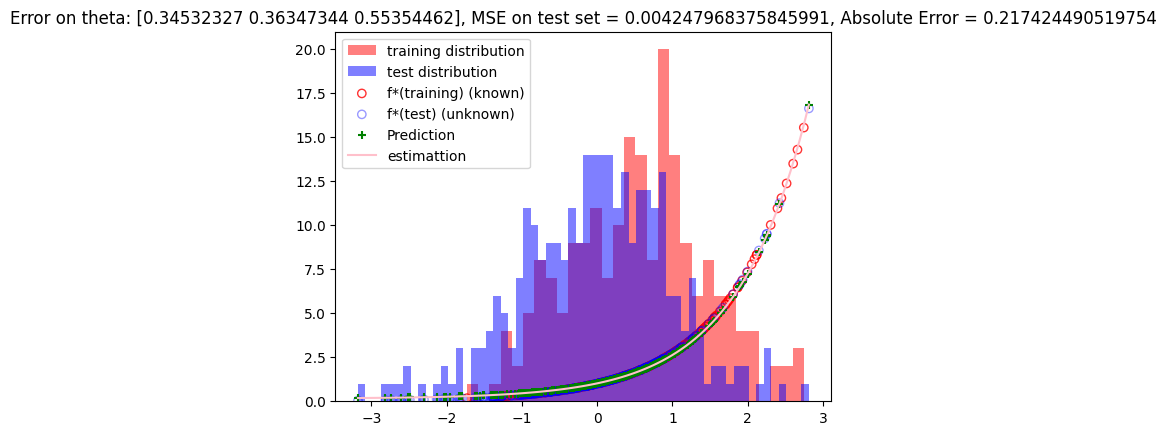

In [ ]:
true_f = lambda x: np.exp(x)

n_tr = 200
n_te = 300

mu_tr, sigma_tr = 1/2, 1
mu_te, sigma_te = 0, 1

x_tr = np.random.normal(loc = mu_tr, scale = sigma_tr**2, size = n_tr)
#x_tr = -np.random.exponential(mu_tr, n_tr)
#x_tr = np.random.exponential(mu_tr, n_tr)
x_te = np.random.normal(loc = mu_te, scale = sigma_te**2, size = n_te)

y_tr = true_f(x_tr)
y_te = true_f(x_te)

training_set = np.zeros((2, n_tr))
training_set[0, :], training_set[1, :] = x_tr, y_tr

plt.hist(x_tr, bins = 30, color = "r", label = "training distribution", alpha = 0.5)
plt.hist(x_te, bins = 60, color = "b", label = "test distribution", alpha = 0.5)
plt.scatter(x_tr, y_tr, facecolors = 'none', edgecolors = 'r', label = "f*(training) (known)", alpha = 0.8)
plt.scatter(x_te, y_te, facecolors = 'none', edgecolors = 'b', label = "f*(test) (unknown)", alpha = 0.4)

#f = lambda x, theta: (1 / (np.sqrt(2 * np.pi * theta[1]**2))) * np.exp(-((x - theta[0])**2) / (2 * theta[1]**2))
perturbation = 0.5
#f = lambda x, theta: (x- theta + perturbation)**2
#f = lambda x, theta: theta[0] + theta[1]*np.cos(x*theta[2])
f = lambda x, theta: theta[0] + theta[1]*np.exp(theta[2]*x)
dim_theta = 3
#dimension_of_parameter = n_te
#theta = np.zeros((1, n_te))
#f = lambda x, theta: np.sum([theta[i] * K(x, x_te[i]) for i in range(n_te)])

#f = lambda x, theta: x*theta
L = lambda x,y: np.linalg.norm(x-y)**2

#theta_opti = met.IWCV(f, dimension_of_parameter, L, x_te, training_set, 0.5, 0.2)
theta_opti, f_opti = met.IWCV(f, dim_theta, L, x_te, training_set, 0.5, 0.2)


#f_opti = lambda x: f(x, theta_opti)
#print(theta_opti)
plt.scatter(x_te, f_opti(x_te), label ="Prediction", color = "green", marker = "+")
y_2 = np.linspace(min(x_te), max(x_te),100)
plt.plot(y_2, f_opti(y_2), color = "pink", label ="estimattion")


#Compute MSE on test set:
avg_MSE_test = np.linalg.norm(f_opti(x_te) - y_te) / n_te
AE = max(np.abs(f_opti(x_te) - y_te))

plt.title(f"Error on theta: {np.abs(theta_opti - perturbation)}, MSE on test set = {avg_MSE_test}, Absolute Error = {AE}")
plt.legend()

#textbox = '\n'.join([
#    f"Error on theta: {np.abs(theta_opti - perturbation)}",
#    f"MSE on test set: {avg_MSE_test}",
#    f"Absolute Error = {AE}"
#])

# Define the properties for the bounding box (fixing the key name)
#bbox_ = dict(boxstyle = "square", facecolor = "gray", alpha = 1)#0.5)

# Adding the text directly to the default figure
#plt.text(0.5, 0.9, textbox, fontsize = 10, bbox = bbox_, verticalalignment = "top")#, ha="right")


Don't actually need to do this or what?

In [41]:
precision = 10
zero_minimum =0
gamma_range = np.linspace(zero_minimum, 1, precision)
lambda_range = np.linspace(zero_minimum, 1, precision)

true_f = lambda x: np.exp(x)
perturbation = 0.5
f = lambda x, theta: (x- theta)**2


n_tr, n_te = 200, 200

mu_tr, sigma_tr = 1, 1
mu_te, sigma_te = 3, 1.1

x_tr = -np.random.exponential(mu_tr, n_tr)
x_te = np.random.normal(loc = mu_te, scale = sigma_te**2, size = n_te)

y_tr, y_te = true_f(x_tr), true_f(x_te)

training_set = np.zeros((2, n_tr))
training_set[0, :], training_set[1, :] = x_tr, y_tr

MSE_matrix = np.zeros((precision, precision))

for i in range(precision):
    for j in range(precision):
        theta_opti = met.IWCV(f, L, x_te, training_set, gamma_range[i], lambda_range[i])
        f_theta = lambda x: f(x, theta_opti)
        tmp = np.linalg.norm(f_theta(x_te)-y_te)
        
        MSE_matrix[i, j] = tmp/n_te
                        


fig = plt.figure(figsize = (20, 10))
ax = fig.add_subplot(111, projection='3d')
X, Y = np.meshgrid(gamma_range, lambda_range)
surf = ax.plot_surface(X, Y, MSE_matrix, cmap='viridis', edgecolor='none') 
fig.colorbar(surf, shrink=0.5, aspect=10)
ax.set_xlabel('Tested flattening parameters (gamma)')
ax.set_ylabel('Tested regularization parameters (lambda)')
ax.set_zlabel('MSE given (gamma, lambda)')
ax.set_title(f"MSE given flatteing and regularization parameters. Minimum is {np.min(MSE_matrix)}")
plt.show()


min_index = np.argmin(MSE_matrix)  
gamma_opti_arg, lambda_opti_arg = np.unravel_index(min_index, MSE_matrix.shape)
gamma_opti, lambda_opti = gamma_range[gamma_opti_arg], lambda_range[lambda_opti_arg]

print(f"Estimated flattening and regularization parameters that achieve (approx.) minimum on the generalization error: ({gamma_opti}, {lambda_opti})")

TypeError: IWCV() missing 1 required positional argument: 'lamb'

Regularizations paths and evolution of the IWCV

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 2.0417183885738526e-14
        x: [-3.057e-07  1.000e+00  1.000e+00]
      nit: 16
      jac: [-1.263e-08  2.535e-08  1.083e-07]
 hess_inv: [[ 3.281e+00 -2.254e+00  8.259e-01]
            [-2.254e+00  1.889e+00 -7.193e-01]
            [ 8.259e-01 -7.193e-01  2.850e-01]]
     nfev: 92
     njev: 23
ici:  [-3.05688831e-07  1.00000026e+00  9.99999893e-01]
  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 2.0417183885738526e-14
        x: [-3.057e-07  1.000e+00  1.000e+00]
      nit: 16
      jac: [-1.263e-08  2.535e-08  1.083e-07]
 hess_inv: [[ 3.281e+00 -2.254e+00  8.259e-01]
            [-2.254e+00  1.889e+00 -7.193e-01]
            [ 8.259e-01 -7.193e-01  2.850e-01]]
     nfev: 92
     njev: 23
ici:  [-3.05688831e-07  1.00000026e+00  9.99999893e-01]
  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 2.0417183885738526e-14


KeyboardInterrupt: 

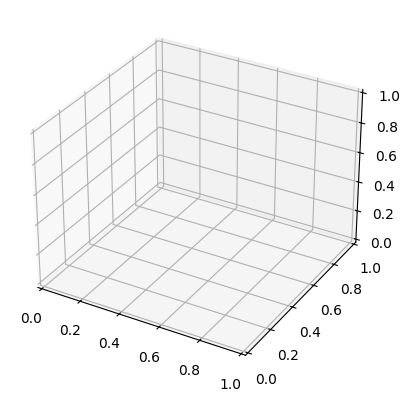

In [ ]:
true_f = lambda x: np.exp(x)

n_tr = 200
n_te = 300

mu_tr, sigma_tr = 1/2, 1
mu_te, sigma_te = 0, 1

x_tr = np.random.normal(loc = mu_tr, scale = sigma_tr**2, size = n_tr)
#x_tr = -np.random.exponential(mu_tr, n_tr)
#x_tr = np.random.exponential(mu_tr, n_tr)
x_te = np.random.normal(loc = mu_te, scale = sigma_te**2, size = n_te)

y_tr = true_f(x_tr)
y_te = true_f(x_te)

training_set = np.zeros((2, n_tr))
training_set[0, :], training_set[1, :] = x_tr, y_tr

#plt.hist(x_tr, bins = 30, color = "r", label = "training distribution", alpha = 0.5)
#plt.hist(x_te, bins = 60, color = "b", label = "test distribution", alpha = 0.5)
#plt.scatter(x_tr, y_tr, facecolors = 'none', edgecolors = 'r', label = "f*(training) (known)", alpha = 0.8)
#plt.scatter(x_te, y_te, facecolors = 'none', edgecolors = 'b', label = "f*(test) (unknown)", alpha = 0.4)

#f = lambda x, theta: (1 / (np.sqrt(2 * np.pi * theta[1]**2))) * np.exp(-((x - theta[0])**2) / (2 * theta[1]**2))
perturbation = 0.5
#f = lambda x, theta: (x- theta + perturbation)**2
#f = lambda x, theta: theta[0] + theta[1]*np.cos(x*theta[2])
f = lambda x, theta: theta[0] + theta[1]*np.exp(theta[2]*x)
dim_theta = 3
#dimension_of_parameter = n_te
#theta = np.zeros((1, n_te))
#f = lambda x, theta: np.sum([theta[i] * K(x, x_te[i]) for i in range(n_te)])

#f = lambda x, theta: x*theta
L = lambda x,y: np.linalg.norm(x-y)**2


lambda_grid = np.linspace(0,1, 20)
gamma_grid = np.linspace(0,1, 20)

#theta_opti, f_opti = met.IWCV(f, dim_theta, L, x_te, training_set, 0.5, 0.2)

#grid_search = np.zeros((len(gamma_grid), len(lambda_grid)))

grid_search = np.empty((len(gamma_grid), len(lambda_grid)), dtype=object)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for i in range(len(gamma_grid)):
    for j in range(len(lambda_grid)):
        tmp, _ = met.IWCV(f, dim_theta, L, x_te, training_set, gamma_grid[i], lambda_grid[i])
        print("ici: ", tmp)
        grid_search[i, j] = tmp
        
for k in range(dim_theta):
    to_plot = np.zeros((len(gamma_grid), len(lambda_grid)))

    for i in range(len(gamma_grid)):
        for j in range(len(lambda_grid)):
            to_plot[i, j] = grid_search[i,j][k]

    
    ax.plot(gamma_grid, lambda_grid, to_plot, label = f"theta_{k}")
            




In [23]:
print(gamma_grid.shape, lambda_grid.shape, to_plot.shape)

(20,) (20,) (20, 20)


In [39]:
X, Y = np.meshgrid(gamma_grid, lambda_grid)

ax.plot3D(gamma_grid.T, lambda_grid, to_plot, label = f"theta_{k}")
plt.show()


ValueError: input operand has more dimensions than allowed by the axis remapping

In [ ]:
ax.scatter3D(gamma_grid, lambda_grid, to_plot)

AttributeError: module 'matplotlib.pyplot' has no attribute 'scatter3D'